In [1]:
import findspark
import happybase
import pandas as pd
import numpy as np

In [2]:
findspark.init()

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = (
    SparkSession.builder
    .appName("StackExchange")
    .getOrCreate()
)

23/12/16 12:31:46 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
23/12/16 12:31:46 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/12/16 12:31:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
VM_address = 'localhost'
conn = happybase.Connection(VM_address)

# Wczytanie danych ze StackOverflow

In [5]:
table_name = 'stackoverflow'
table_stackoverflow = conn.table(table_name)

In [6]:
df_online_rows = []
df_online_tags_rows = []

for key, data in table_stackoverflow.scan():
    last_edit_date = int(data.get(b'post_details:last_edit_date', b'0').decode('UTF-8'))
    if last_edit_date == 0:
        last_edit_date = None
        
    owner_account_id = int(data.get(b'owner:account_id', b'0').decode('UTF-8'))
    if owner_account_id == 0:
        owner_account_id = None
        
    owner_reputation = int(data.get(b'owner:reputation', b'-1000000000').decode('UTF-8'))
    if owner_reputation == -1000000000:
        owner_reputation = None
    
    owner_user_id = int(data.get(b'owner:user_id', b'-1000000000').decode('UTF-8'))
    if owner_user_id == -1000000000:
        owner_user_id = None
        
    new_row = {
        'owner_account_id': owner_account_id,
        'owner_reputation': owner_reputation,
        'owner_user_id': owner_user_id,
        'owner_user_type': data[b'owner:user_type'].decode('UTF-8'),
        'post_answer_count': int(data[b'post_details:answer_count'].decode('UTF-8')),
        'post_creation_date': int(data[b'post_details:creation_date'].decode('UTF-8')),
        'post_is_answered': bool(data[b'post_details:is_answered'].decode('UTF-8')),
        'post_last_activity_date': int(data[b'post_details:last_activity_date'].decode('UTF-8')),
        'post_last_edit_date': last_edit_date,
        'post_score': int(data[b'post_details:score'].decode('UTF-8')),
        'post_title': data[b'post_details:title'].decode('UTF-8'),
        'post_view_count': int(data[b'post_details:view_count'].decode('UTF-8')),
        'question_id': int(key.decode('UTF-8'))
    }
    df_online_rows.append(new_row)
    tags = [t.strip('"') for t in data[b'tags:tags'].decode('UTF-8').strip('[]').split(',')]
    for tag in tags:
        df_online_tags_rows.append({'question_id': new_row['question_id'],
                                   'tag': tag})
        
df_online = pd.DataFrame(df_online_rows)
df_online_tags = pd.DataFrame(df_online_tags_rows)

In [7]:
df_online

,owner_account_id,owner_reputation,owner_user_id,owner_user_type,post_answer_count,post_creation_date,post_is_answered,post_last_activity_date,post_last_edit_date,post_score,post_title,post_view_count,question_id
0,117126.0,545.0,306857.0,registered,1,1676241304,True,1676246557,None,0,"Echo input into output, at the right place",106,75430619
1,24174919.0,13.0,18136532.0,registered,0,1676241369,True,1676241369,None,0,How to compute impulse responses for Bayesian ...,60,75430621
2,18517358.0,100.0,13491206.0,registered,0,1676241414,True,1676241414,None,1,Flutter QuillEditor not following cursor insid...,199,75430622
3,27769408.0,1.0,21199996.0,registered,0,1676241468,True,1689061931,None,0,Unable to render parametric equations in Manim,121,75430626
4,27741092.0,1.0,21177532.0,registered,0,1676241504,True,1676241536,None,0,Maya Python GUI - Making a picker - how to be ...,161,75430628
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,7473671.0,1372.0,6196488.0,registered,1,1702418256,True,1702419831,None,0,Pass Options into Common Autocomplete Component,21,77649231
35996,1589784.0,5319.0,1601580.0,registered,0,1702418294,True,1702418294,None,0,How to install swarms; AssertionError: Error: ...,14,77649233
35997,29875494.0,1.0,23090249.0,registered,1,1702418308,True,1702484496,None,0,WinError 10061 : NLTK - No connection could be...,20,77649234
35998,19821205.0,187.0,14517741.0,registered,1,1702418325,True,1702425432,None,0,Console application solutions can&#39;t be bui...,58,77649235


In [8]:
df_online_tags

,question_id,tag
0,75430619,c
1,75430619,input
2,75430619,io
3,75430619,user-input
4,75430619,io-redirection
...,...,...
110855,77649234,windows-firewall
110856,77649235,c#
110857,77649235,.net
110858,77649235,visual-studio


# Wczytanie danych z Data Science StackExchange

In [9]:
table_name = 'datascience_posts'
table_datascience_posts = conn.table(table_name)
table_name = 'datascience_users'
table_datascience_users = conn.table(table_name)

In [10]:
df_static_posts_rows = []
df_static_tags_rows = []

for key, data in table_datascience_posts.scan():
    last_edit_date = data.get(b'post:lastEditDate', b'').decode('UTF-8')
    if last_edit_date == '':
        last_edit_date = None
    
    closed_date = data.get(b'post:closedDate', b'').decode('UTF-8')
    if closed_date == '':
        closed_date = None
        
    owner_user_id = int(data.get(b'post:ownerUserId', b'0').decode('UTF-8'))
    if owner_user_id == 0:
        owner_user_id = None
        
    new_row = {
        'answer_count': int(data[b'post:answerCount'].decode('UTF-8')),
        'comment_count': int(data[b'post:commentCount'].decode('UTF-8')),
        'creation_date': data[b'post:creationDate'].decode('UTF-8'),
        'last_activity_date': data[b'post:lastActivityDate'].decode('UTF-8'),
        'last_edit_date': last_edit_date,
        'closed_date': closed_date,
        'owner_user_id': owner_user_id,
        'score': int(data[b'post:score'].decode('UTF-8')),
        'view_count': int(data[b'post:viewCount'].decode('UTF-8')),
        'question_id': key.decode('UTF-8'),
    }
    df_static_posts_rows.append(new_row)
    tags = data[b'tags:tags'].decode('UTF-8').strip('<>').split('><')
    for tag in tags:
        df_static_tags_rows.append({'question_id': new_row['question_id'],
                                   'tag': tag})
        
df_static_posts = pd.DataFrame(df_static_posts_rows)
df_static_tags = pd.DataFrame(df_static_tags_rows)

In [11]:
df_static_posts

,answer_count,comment_count,creation_date,last_activity_date,last_edit_date,closed_date,owner_user_id,score,view_count,question_id
0,1,2,2016-01-27T19:58:00.083,2017-12-27T20:43:21.200,2016-01-27T21:00:53.283,None,8820.0,15,7402,10000
1,2,0,2021-08-12T18:39:11.853,2021-08-18T12:36:43.523,None,None,121019.0,1,215,100001
2,0,3,2021-08-12T19:03:02.970,2021-08-12T19:03:02.970,None,None,122641.0,0,114,100003
3,0,2,2021-08-12T19:11:52.057,2021-08-12T19:11:52.057,None,None,120849.0,0,58,100005
4,1,0,2021-08-12T22:02:42.877,2021-08-14T01:20:57.533,None,None,112224.0,0,117,100010
...,...,...,...,...,...,...,...,...,...,...
36599,2,0,2021-08-12T12:02:47.993,2022-07-23T21:05:25.617,None,None,122916.0,0,1347,99987
36600,1,3,2016-01-27T19:56:50.257,2016-01-28T21:54:28.953,None,None,15797.0,4,2755,9999
36601,0,0,2021-08-12T15:52:27.427,2021-08-12T15:52:27.427,None,None,21254.0,1,280,99995
36602,1,1,2021-08-12T16:00:51.823,2021-08-13T09:09:35.563,2021-08-12T19:53:56.573,None,51670.0,0,22,99996


In [12]:
df_static_tags

,question_id,tag
0,10000,bayesian-networks
1,10000,pgm
2,100001,machine-learning
3,100001,nlp
4,100001,transformer
...,...,...
112398,99996,semantic-similarity
112399,99998,machine-learning
112400,99998,python
112401,99998,clustering


In [13]:
df_static_users_rows = []

for key, data in table_datascience_users.scan():
    location = data.get(b'user:location', b'').decode('UTF-8')
    if location == '':
        location = None
        
    new_row = {
        'location': owner_reputation,
        'creation_date': data[b'user:creationDate'].decode('UTF-8'),
        'down_votes': int(data[b'user:downVotes'].decode('UTF-8')),
        'up_votes': int(data[b'user:upVotes'].decode('UTF-8')),
        'reputation': int(data[b'user:reputation'].decode('UTF-8')),
        'views': int(data[b'user:views'].decode('UTF-8')),
        'user_id': int(key.decode('UTF-8')),
    }
    df_static_users_rows.append(new_row)
        
df_static_users = pd.DataFrame(df_static_users_rows)

In [14]:
df_static_users

,location,creation_date,down_votes,up_votes,reputation,views,user_id
0,1030,2014-05-13T21:29:22.820,2148,841,1,495,-1
1,1030,2014-05-13T22:58:54.810,0,0,101,723,1
2,1030,2014-05-13T23:18:31.953,0,1,101,5,10
3,1030,2014-05-14T06:06:21.970,0,38,101,2,100
4,1030,2014-06-19T05:17:11.773,0,0,1,3,1000
...,...,...,...,...,...,...,...
134331,1030,2020-06-30T13:01:53.917,0,0,1,0,99995
134332,1030,2020-06-30T14:17:23.050,0,0,1,0,99996
134333,1030,2020-06-30T14:24:42.103,0,0,101,0,99997
134334,1030,2020-06-30T14:47:15.887,0,0,1,0,99998


# Wczytywanie danych do Sparka

## Stackoverflow

In [15]:
pd.__version__

'1.3.3'

In [16]:
df_stackoverflow = spark.createDataFrame(df_online.drop(columns=['post_last_edit_date']))\
    .withColumn('post_last_activity_date', f.to_date(f.from_unixtime('post_last_activity_date', 'yyyy-MM-dd HH:mm:ss')))\
    .withColumn('post_creation_date', f.to_date(f.from_unixtime('post_creation_date', 'yyyy-MM-dd HH:mm:ss')))
# df_stackoverflow = spark.createDataFrame(df_online)
df_stackoverflow.printSchema()

root
 |-- owner_account_id: double (nullable = true)
 |-- owner_reputation: double (nullable = true)
 |-- owner_user_id: double (nullable = true)
 |-- owner_user_type: string (nullable = true)
 |-- post_answer_count: long (nullable = true)
 |-- post_creation_date: date (nullable = true)
 |-- post_is_answered: boolean (nullable = true)
 |-- post_last_activity_date: date (nullable = true)
 |-- post_score: long (nullable = true)
 |-- post_title: string (nullable = true)
 |-- post_view_count: long (nullable = true)
 |-- question_id: long (nullable = true)



In [17]:
df_stackoverflow.show(n=1)

23/12/16 12:32:12 WARN scheduler.TaskSetManager: Stage 0 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.


+----------------+----------------+-------------+---------------+-----------------+------------------+----------------+-----------------------+----------+--------------------+---------------+-----------+
|owner_account_id|owner_reputation|owner_user_id|owner_user_type|post_answer_count|post_creation_date|post_is_answered|post_last_activity_date|post_score|          post_title|post_view_count|question_id|
+----------------+----------------+-------------+---------------+-----------------+------------------+----------------+-----------------------+----------+--------------------+---------------+-----------+
|        117126.0|           545.0|     306857.0|     registered|                1|        2023-02-12|            true|             2023-02-13|         0|Echo input into o...|            106|   75430619|
+----------------+----------------+-------------+---------------+-----------------+------------------+----------------+-----------------------+----------+--------------------+---------

## StackOverflow tags

In [18]:
df_stackoverflow_tags = spark.createDataFrame(df_online_tags)
df_stackoverflow_tags.printSchema()

root
 |-- question_id: long (nullable = true)
 |-- tag: string (nullable = true)



In [19]:
df_stackoverflow_tags.show(n=3)

+-----------+-----+
|question_id|  tag|
+-----------+-----+
|   75430619|    c|
|   75430619|input|
|   75430619|   io|
+-----------+-----+
only showing top 3 rows



23/12/16 12:32:16 WARN scheduler.TaskSetManager: Stage 1 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


## DataScience posts

In [20]:
df_datascience_posts = spark.createDataFrame(df_static_posts)\
    .withColumn('last_activity_date', f.to_date('last_activity_date'))\
    .withColumn('last_edit_date', f.to_date('last_edit_date'))\
    .withColumn('creation_date', f.to_date('creation_date'))\
    .withColumn('closed_date', f.to_date('closed_date'))
df_datascience_posts.printSchema()

root
 |-- answer_count: long (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- creation_date: date (nullable = true)
 |-- last_activity_date: date (nullable = true)
 |-- last_edit_date: date (nullable = true)
 |-- closed_date: date (nullable = true)
 |-- owner_user_id: double (nullable = true)
 |-- score: long (nullable = true)
 |-- view_count: long (nullable = true)
 |-- question_id: string (nullable = true)



In [21]:
df_datascience_posts.show(n=3)

+------------+-------------+-------------+------------------+--------------+-----------+-------------+-----+----------+-----------+
|answer_count|comment_count|creation_date|last_activity_date|last_edit_date|closed_date|owner_user_id|score|view_count|question_id|
+------------+-------------+-------------+------------------+--------------+-----------+-------------+-----+----------+-----------+
|           1|            2|   2016-01-27|        2017-12-27|    2016-01-27|       null|       8820.0|   15|      7402|      10000|
|           2|            0|   2021-08-12|        2021-08-18|          null|       null|     121019.0|    1|       215|     100001|
|           0|            3|   2021-08-12|        2021-08-12|          null|       null|     122641.0|    0|       114|     100003|
+------------+-------------+-------------+------------------+--------------+-----------+-------------+-----+----------+-----------+
only showing top 3 rows



23/12/16 12:32:18 WARN scheduler.TaskSetManager: Stage 2 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


## DataScience tags

In [22]:
df_datascience_tags = spark.createDataFrame(df_static_tags)
df_datascience_tags.printSchema()

root
 |-- question_id: string (nullable = true)
 |-- tag: string (nullable = true)



In [23]:
df_datascience_tags.show(n=3)

+-----------+-----------------+
|question_id|              tag|
+-----------+-----------------+
|      10000|bayesian-networks|
|      10000|              pgm|
|     100001| machine-learning|
+-----------+-----------------+
only showing top 3 rows



23/12/16 12:32:21 WARN scheduler.TaskSetManager: Stage 3 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


## DataScience users

In [24]:
df_static_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134336 entries, 0 to 134335
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   location       134336 non-null  int64 
 1   creation_date  134336 non-null  object
 2   down_votes     134336 non-null  int64 
 3   up_votes       134336 non-null  int64 
 4   reputation     134336 non-null  int64 
 5   views          134336 non-null  int64 
 6   user_id        134336 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 7.2+ MB


In [25]:
df_datascience_users = spark.createDataFrame(df_static_users)\
    .withColumn('creation_date', f.to_date('creation_date'))
df_datascience_users.printSchema()

root
 |-- location: long (nullable = true)
 |-- creation_date: date (nullable = true)
 |-- down_votes: long (nullable = true)
 |-- up_votes: long (nullable = true)
 |-- reputation: long (nullable = true)
 |-- views: long (nullable = true)
 |-- user_id: long (nullable = true)



In [26]:
df_datascience_users.show(n=3)

+--------+-------------+----------+--------+----------+-----+-------+
|location|creation_date|down_votes|up_votes|reputation|views|user_id|
+--------+-------------+----------+--------+----------+-----+-------+
|    1030|   2014-05-13|      2148|     841|         1|  495|     -1|
|    1030|   2014-05-13|         0|       0|       101|  723|      1|
|    1030|   2014-05-13|         0|       1|       101|    5|     10|
+--------+-------------+----------+--------+----------+-----+-------+
only showing top 3 rows



23/12/16 12:32:27 WARN scheduler.TaskSetManager: Stage 4 contains a task of very large size (2942 KiB). The maximum recommended task size is 1000 KiB.


# Analiza danych

In [28]:
import matplotlib.pyplot as plt

In [29]:
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data science

In [30]:
df1_1 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .count()\
    .orderBy('year')\
    .toPandas()

23/12/16 12:33:16 WARN scheduler.TaskSetManager: Stage 5 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [143]:
df1_1

,year,count
0,2014,559
1,2015,1161
2,2016,2112
3,2017,2916
4,2018,5326
5,2019,6749
6,2020,6131
7,2021,4713
8,2022,3531


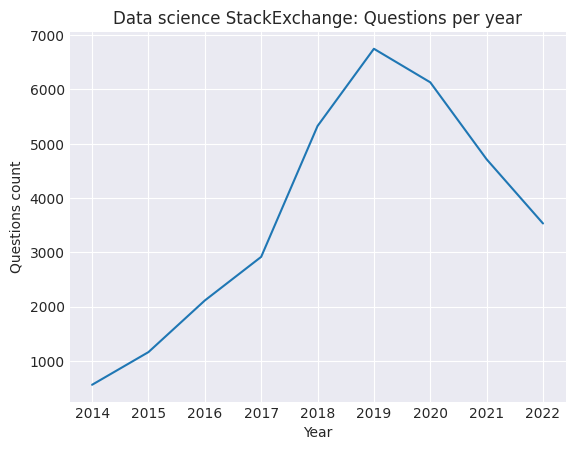

In [31]:
plt.plot(df1_1['year'], df1_1['count'])
plt.xlabel('Year')
plt.ylabel('Questions count')
plt.title('Data science StackExchange: Questions per year')
plt.show()

In [32]:
df1_2 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') == 2019)\
    .withColumn('month', f.month('creation_date'))\
    .groupBy('month')\
    .count()\
    .orderBy('month')\
    .toPandas()

23/12/16 12:33:24 WARN scheduler.TaskSetManager: Stage 10 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [142]:
df1_2

,month,count
0,1,459
1,2,613
2,3,658
3,4,590
4,5,591
5,6,604
6,7,656
7,8,574
8,9,507
9,10,442


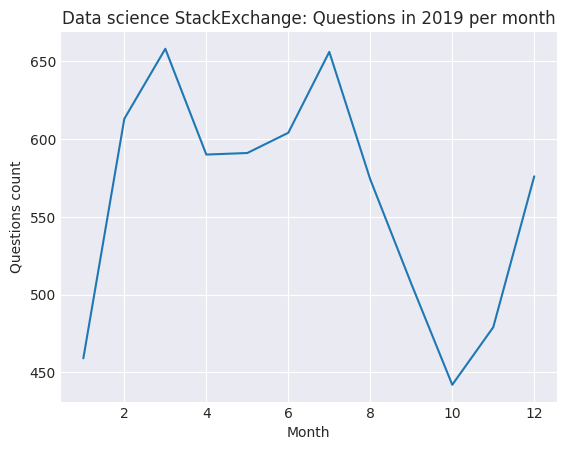

In [33]:
plt.plot(df1_2['month'], df1_2['count'])
plt.xlabel('Month')
plt.ylabel('Questions count')
plt.title('Data science StackExchange: Questions in 2019 per month')
plt.show()

### Analiza dla najbardziej aktywnego roku (2019)

In [34]:
df1_3 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') == 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 12:33:29 WARN scheduler.TaskSetManager: Stage 15 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:33:29 WARN scheduler.TaskSetManager: Stage 16 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [141]:
df1_3

,tag,count
0,machine-learning,2130
1,python,1439
2,deep-learning,895
3,neural-network,823
4,keras,705
5,classification,577
6,scikit-learn,448
7,nlp,443
8,tensorflow,409
9,cnn,378


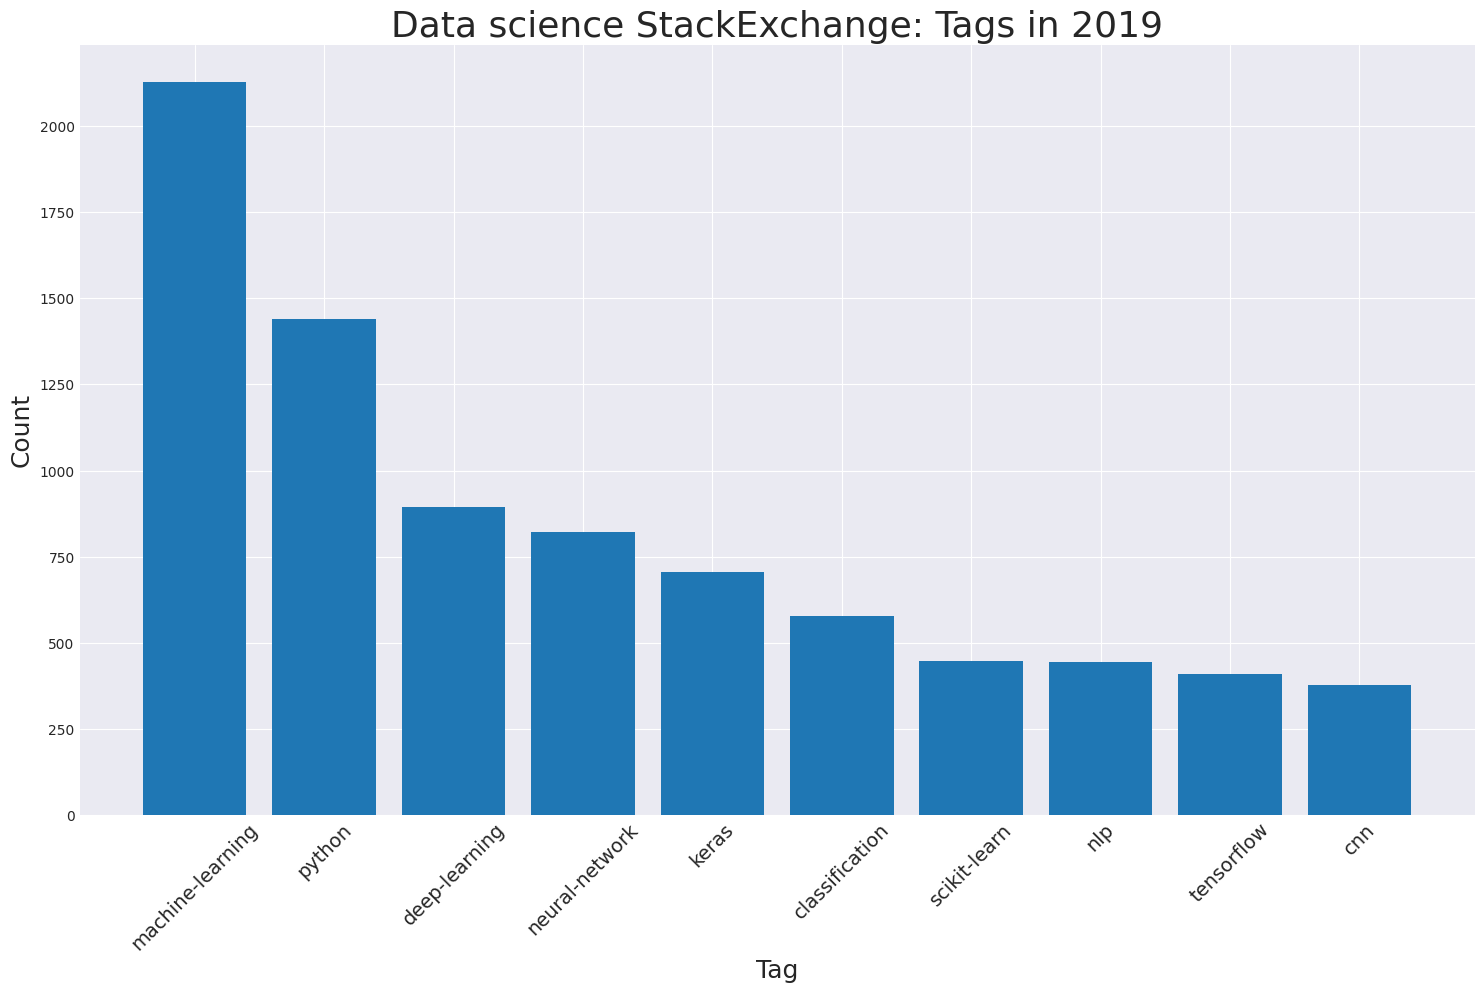

In [35]:
plt.figure(figsize=(18, 10))
plt.bar(df1_3['tag'], df1_3['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags in 2019', fontsize=26)
plt.show()

### Analiza przed i po 2019

In [36]:
df1_4 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') < 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 12:33:38 WARN scheduler.TaskSetManager: Stage 19 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:33:39 WARN scheduler.TaskSetManager: Stage 20 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.


In [140]:
df1_4

,tag,count
0,machine-learning,4085
1,python,2016
2,neural-network,1819
3,deep-learning,1514
4,classification,1173
5,r,824
6,keras,767
7,scikit-learn,745
8,data-mining,696
9,nlp,681


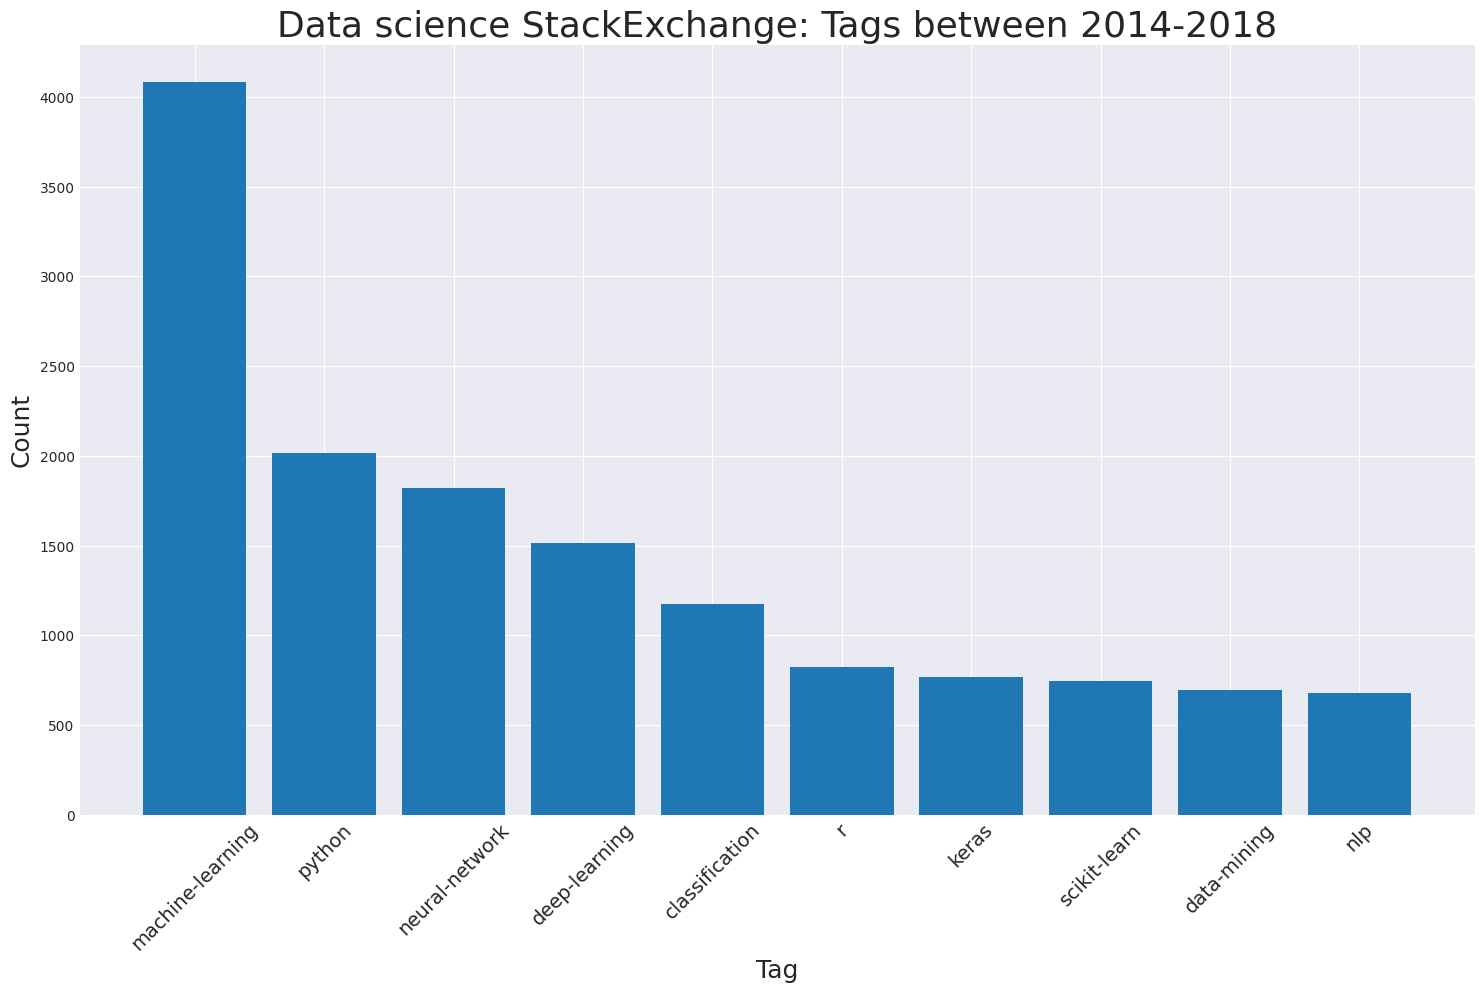

In [37]:
plt.figure(figsize=(18, 10))
plt.bar(df1_4['tag'], df1_4['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags between 2014-2018', fontsize=26)
plt.show()

In [38]:
df1_5 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') > 2019)\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 12:33:47 WARN scheduler.TaskSetManager: Stage 23 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:33:47 WARN scheduler.TaskSetManager: Stage 24 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [139]:
df1_5

,tag,count
0,machine-learning,5091
1,python,3213
2,deep-learning,2431
3,neural-network,1720
4,nlp,1564
5,classification,1500
6,keras,1269
7,tensorflow,1192
8,scikit-learn,1106
9,time-series,1021


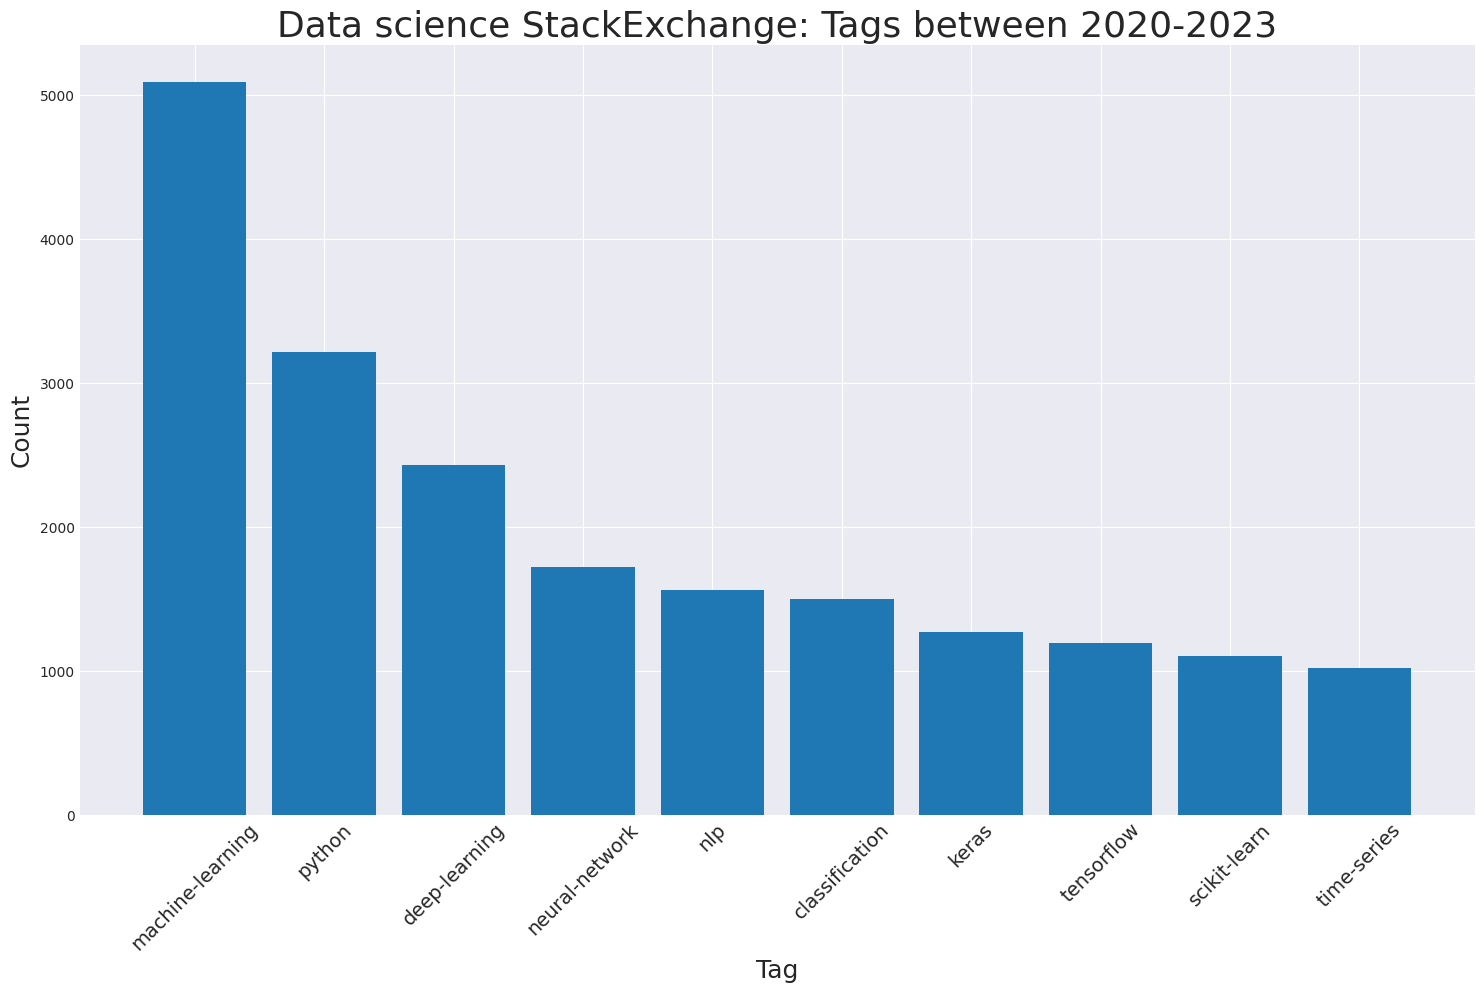

In [39]:
plt.figure(figsize=(18, 10))
plt.bar(df1_5['tag'], df1_5['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Data science StackExchange: Tags between 2020-2023', fontsize=26)
plt.show()

### Porównanie dwóch kluczowych języków programowania do przetwarzania i analizy danych

In [40]:
df1_6 = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('year', 'tag')\
    .count()\
    .orderBy('year')
df1_6_r = df1_6.filter(f.col('tag') == 'r')\
    .toPandas()
df1_6_py = df1_6.filter(f.col('tag') == 'python')\
    .toPandas()

23/12/16 12:33:55 WARN scheduler.TaskSetManager: Stage 27 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:33:55 WARN scheduler.TaskSetManager: Stage 28 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:34:02 WARN scheduler.TaskSetManager: Stage 36 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:34:03 WARN scheduler.TaskSetManager: Stage 37 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [137]:
df1_6_r

,year,tag,count
0,2014,r,54
1,2015,r,153
2,2016,r,210
3,2017,r,204
4,2018,r,203
5,2019,r,194
6,2020,r,191
7,2021,r,128
8,2022,r,83


In [138]:
df1_6_py

,year,tag,count
0,2014,python,43
1,2015,python,130
2,2016,python,313
3,2017,python,473
4,2018,python,1057
5,2019,python,1439
6,2020,python,1203
7,2021,python,900
8,2022,python,609


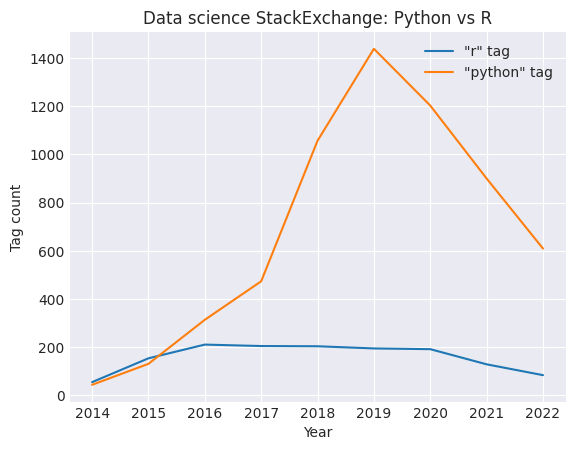

In [41]:
plt.plot(df1_6_r['year'], df1_6_r['count'], label='"r" tag')
plt.plot(df1_6_py['year'], df1_6_py['count'], label='"python" tag')
plt.xlabel('Year')
plt.ylabel('Tag count')
plt.title('Data science StackExchange: Python vs R')
plt.legend()
plt.show()

### Liczba zakładanych kont na przestrzeni lat

In [42]:
df1_7 = df_datascience_users\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .count()\
    .orderBy('year')\
    .toPandas()

23/12/16 12:34:10 WARN scheduler.TaskSetManager: Stage 45 contains a task of very large size (2942 KiB). The maximum recommended task size is 1000 KiB.


In [136]:
df1_7

,year,count
0,2014,3406
1,2015,6141
2,2016,9827
3,2017,14187
4,2018,18928
5,2019,20245
6,2020,19850
7,2021,16606
8,2022,13803


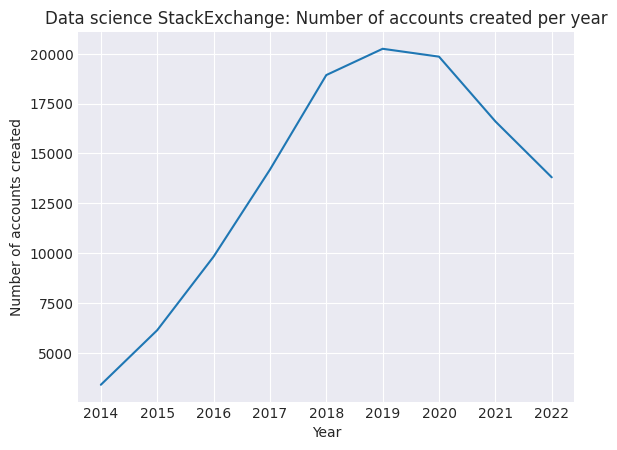

In [43]:
plt.plot(df1_7['year'], df1_7['count'])
plt.xlabel('Year')
plt.ylabel('Number of accounts created')
plt.title('Data science StackExchange: Number of accounts created per year')
plt.show()

### Porównianie średniego score pytań na rok

In [44]:
df1_8 = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .avg('score')\
    .orderBy('year')\
    .toPandas()

23/12/16 12:34:14 WARN scheduler.TaskSetManager: Stage 50 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [135]:
df1_8

,year,avg(score)
0,2014,11.345259
1,2015,5.162791
2,2016,4.799716
3,2017,3.356996
4,2018,2.697522
5,2019,1.849015
6,2020,1.450008
7,2021,0.948228
8,2022,0.676296


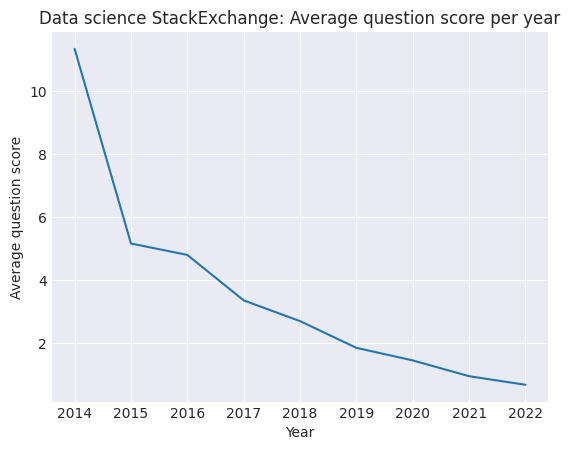

In [45]:
plt.plot(df1_8['year'], df1_8['avg(score)'])
plt.xlabel('Year')
plt.ylabel('Average question score')
plt.title('Data science StackExchange: Average question score per year')
plt.show()

### Różnica między wzrostami/spadkami liczby wyświetleń oraz odpowiedzi do postów

In [46]:
df1_9_answers = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .sum('answer_count')\
    .orderBy('year')\
    .toPandas()
df1_9_views = df_datascience_posts\
    .withColumn('year', f.year('creation_date'))\
    .filter(f.col('year') != 2023)\
    .groupBy('year')\
    .sum('view_count')\
    .orderBy('year')\
    .toPandas()

23/12/16 12:34:17 WARN scheduler.TaskSetManager: Stage 55 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:34:20 WARN scheduler.TaskSetManager: Stage 60 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [133]:
df1_9_answers

,year,sum(answer_count)
0,2014,1367
1,2015,2030
2,2016,3367
3,2017,3911
4,2018,6951
5,2019,8038
6,2020,6525
7,2021,4123
8,2022,2969


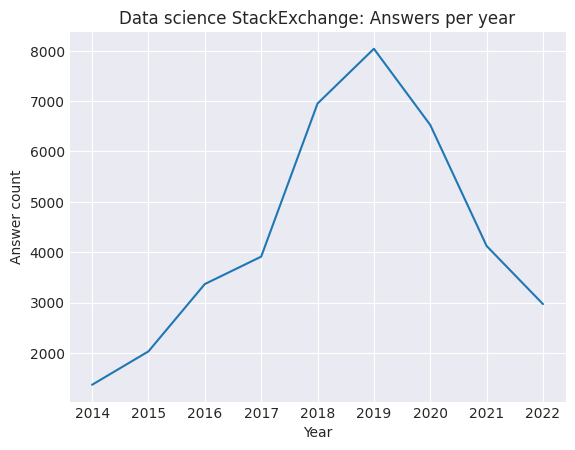

In [47]:
plt.plot(df1_9_answers['year'], df1_9_answers['sum(answer_count)'])
plt.xlabel('Year')
plt.ylabel('Answer count')
plt.title('Data science StackExchange: Answers per year')
plt.show()

In [134]:
df1_9_views

,year,sum(view_count)
0,2014,3816144
1,2015,5607976
2,2016,12636715
3,2017,12478154
4,2018,18286546
5,2019,12538422
6,2020,6114577
7,2021,2578499
8,2022,1160567


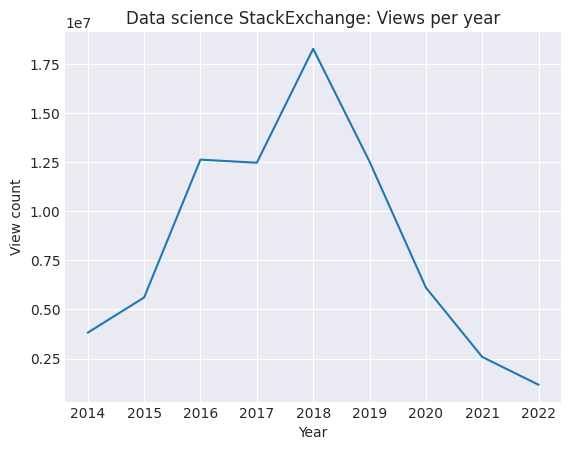

In [48]:
plt.plot(df1_9_views['year'], df1_9_views['sum(view_count)'])
plt.xlabel('Year')
plt.ylabel('View count')
plt.title('Data science StackExchange: Views per year')
plt.show()

# Stack Overflow

## Most popular tags

In [120]:
df2_1 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 13:25:46 WARN scheduler.TaskSetManager: Stage 122 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 13:25:46 WARN scheduler.TaskSetManager: Stage 123 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.


In [132]:
df2_1

,tag,count
0,python,4886
1,javascript,3226
2,reactjs,1932
3,java,1705
4,c#,1571
5,html,1303
6,android,1282
7,r,1077
8,flutter,1029
9,node.js,1006


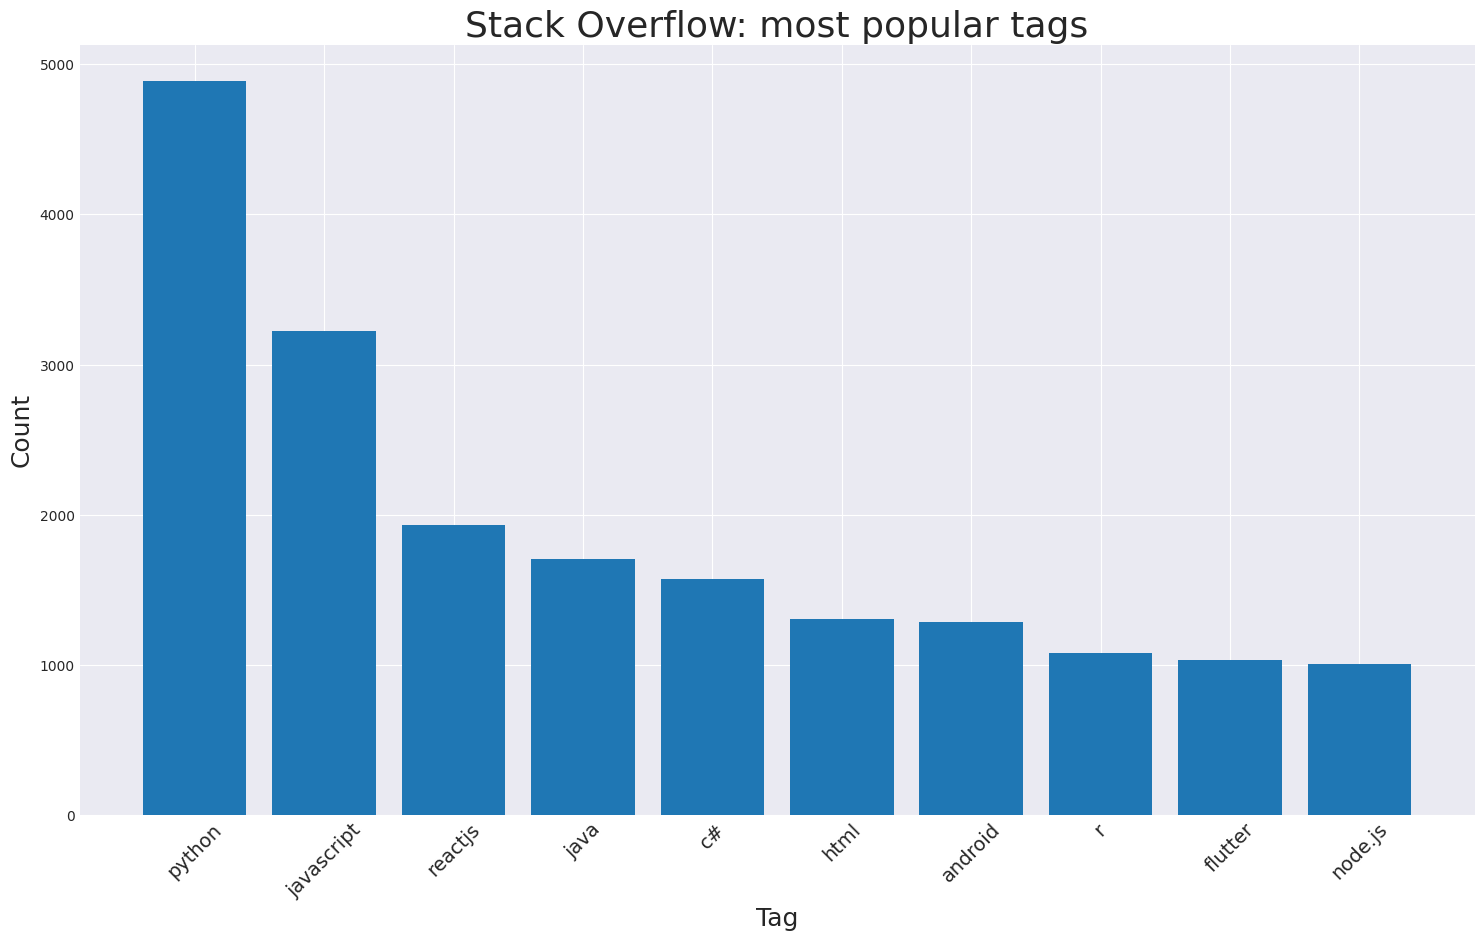

In [121]:
plt.figure(figsize=(18, 10))
plt.bar(df2_1['tag'], df2_1['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags', fontsize=26)
plt.show()

## Most viewed posts

In [69]:
np.bool = bool

In [100]:
df2_2 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .groupBy('question_id', 'post_view_count', 'post_title')\
    .agg(f.concat_ws(", ", f.collect_list(f.col('tag'))).alias("tags"))\
    .orderBy('post_view_count', ascending=False)\
    .toPandas()

23/12/16 13:13:50 WARN scheduler.TaskSetManager: Stage 111 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 13:13:50 WARN scheduler.TaskSetManager: Stage 112 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.


In [101]:
df2_2

,question_id,post_view_count,post_title,tags
0,76541695,228969,Ionic - how to prevent error &quot;TS2339: Pro...,"angular, ionic-framework"
1,76616042,70751,AttributeError: module &#39;PIL.Image&#39; has...,"python, python-imaging-library"
2,76461596,63887,Unable to use Selenium Webdriver. Getting two ...,"python, selenium-webdriver, exception, seleniu..."
3,75894992,48274,Missing file `libarclite_iphoneos.a` in Xcode ...,"ios, flutter, xcode, xcode14, flutter-ios-build"
4,77390141,46481,Shardingsphere and Flyway integration startup ...,"java, spring, flyway, sharding"
...,...,...,...,...
35995,77643596,4,Is it necessary for Apache IoTDB and HDFS to i...,"hdfs, apache-iotdb, iotdb"
35996,77182405,4,trying to install spyder into working environm...,"spyder, anaconda3"
35997,77575791,4,How to keep the windows casting ( WinKey + K) ...,"casting, screen, display, sharing, split-screen"
35998,76336502,3,Intersect method does not appear to work with ...,"forms, methods, intersect"


In [105]:
df2_2[0:10]

,question_id,post_view_count,post_title,tags
0,76541695,228969,Ionic - how to prevent error &quot;TS2339: Pro...,"angular, ionic-framework"
1,76616042,70751,AttributeError: module &#39;PIL.Image&#39; has...,"python, python-imaging-library"
2,76461596,63887,Unable to use Selenium Webdriver. Getting two ...,"python, selenium-webdriver, exception, seleniu..."
3,75894992,48274,Missing file `libarclite_iphoneos.a` in Xcode ...,"ios, flutter, xcode, xcode14, flutter-ios-build"
4,77390141,46481,Shardingsphere and Flyway integration startup ...,"java, spring, flyway, sharding"
5,76049290,35041,Error AccessControlListNotSupported when tryin...,"amazon-web-services, amazon-s3, terraform"
6,76229498,33300,Incorrect use of &lt;label for=FORM_ELEMENT&gt...,"html, section508"
7,75994613,28356,Unable to connect to the server: getting crede...,"azure, kubernetes, kubectl, azure-powershell"
8,76708329,25393,Docker-compose no longer building image (Attri...,"docker, docker-compose, cython, pyyaml"
9,76791937,24801,Issues while building iOS project with flutter,"ios, flutter, xcode"


In [112]:
next(df2_2[0:10].iterrows())

(0,
 question_id                                                 76541695
 post_view_count                                               228969
 post_title         Ionic - how to prevent error &quot;TS2339: Pro...
 tags                                        angular, ionic-framework
 Name: 0, dtype: object)

In [117]:
for rank, data in df2_2[0:10].iterrows():
    print(f'No. ' + f'{rank+1}:'.ljust(4) + f'{data["post_title"]}\n'
          f'\tviews: {data["post_view_count"]}   |   tags: {data["tags"]}')
    print("===================================================================================================================")
# https://stackoverflow.com/questions/76541695/ionic-how-to-prevent-error-ts2339-property-xxx-does-not-exist-on-type

No. 1:  Ionic - how to prevent error &quot;TS2339: Property XXX does not exist on type&quot;
	views: 228969   |   tags: angular, ionic-framework
No. 2:  AttributeError: module &#39;PIL.Image&#39; has no attribute &#39;ANTIALIAS&#39;
	views: 70751   |   tags: python, python-imaging-library
No. 3:  Unable to use Selenium Webdriver. Getting two exceptions
	views: 63887   |   tags: python, selenium-webdriver, exception, selenium-chromedriver
No. 4:  Missing file `libarclite_iphoneos.a` in Xcode 14.3 after update flutter and Xcode
	views: 48274   |   tags: ios, flutter, xcode, xcode14, flutter-ios-build
No. 5:  Shardingsphere and Flyway integration startup error: Schema &#39;xxxx&#39; doesn&#39;t exist
	views: 46481   |   tags: java, spring, flyway, sharding
No. 6:  Error AccessControlListNotSupported when trying to create a bucket ACL in AWS
	views: 35041   |   tags: amazon-web-services, amazon-s3, terraform
No. 7:  Incorrect use of &lt;label for=FORM_ELEMENT&gt; - How to fix?
	views: 3330

## Tags appearing with `python` tag

In [127]:
posts_with_python = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .filter(f.col('tag') == 'python')\
    .withColumnRenamed('tag', 'python_tag')\
    .select('question_id', 'python_tag')
    

In [153]:
df2_3 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .join(posts_with_python, on='question_id', how='left')\
    .filter((f.col('python_tag') == 'python') & (f.col('tag') != 'python'))\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 14:36:50 WARN scheduler.TaskSetManager: Stage 155 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:36:50 WARN scheduler.TaskSetManager: Stage 156 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:36:50 WARN scheduler.TaskSetManager: Stage 157 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


In [147]:
df2_3

,tag,count
0,pandas,511
1,python-3.x,352
2,dataframe,233
3,django,219
4,numpy,174
5,matplotlib,148
6,flask,138
7,selenium-webdriver,138
8,tensorflow,107
9,pytorch,100


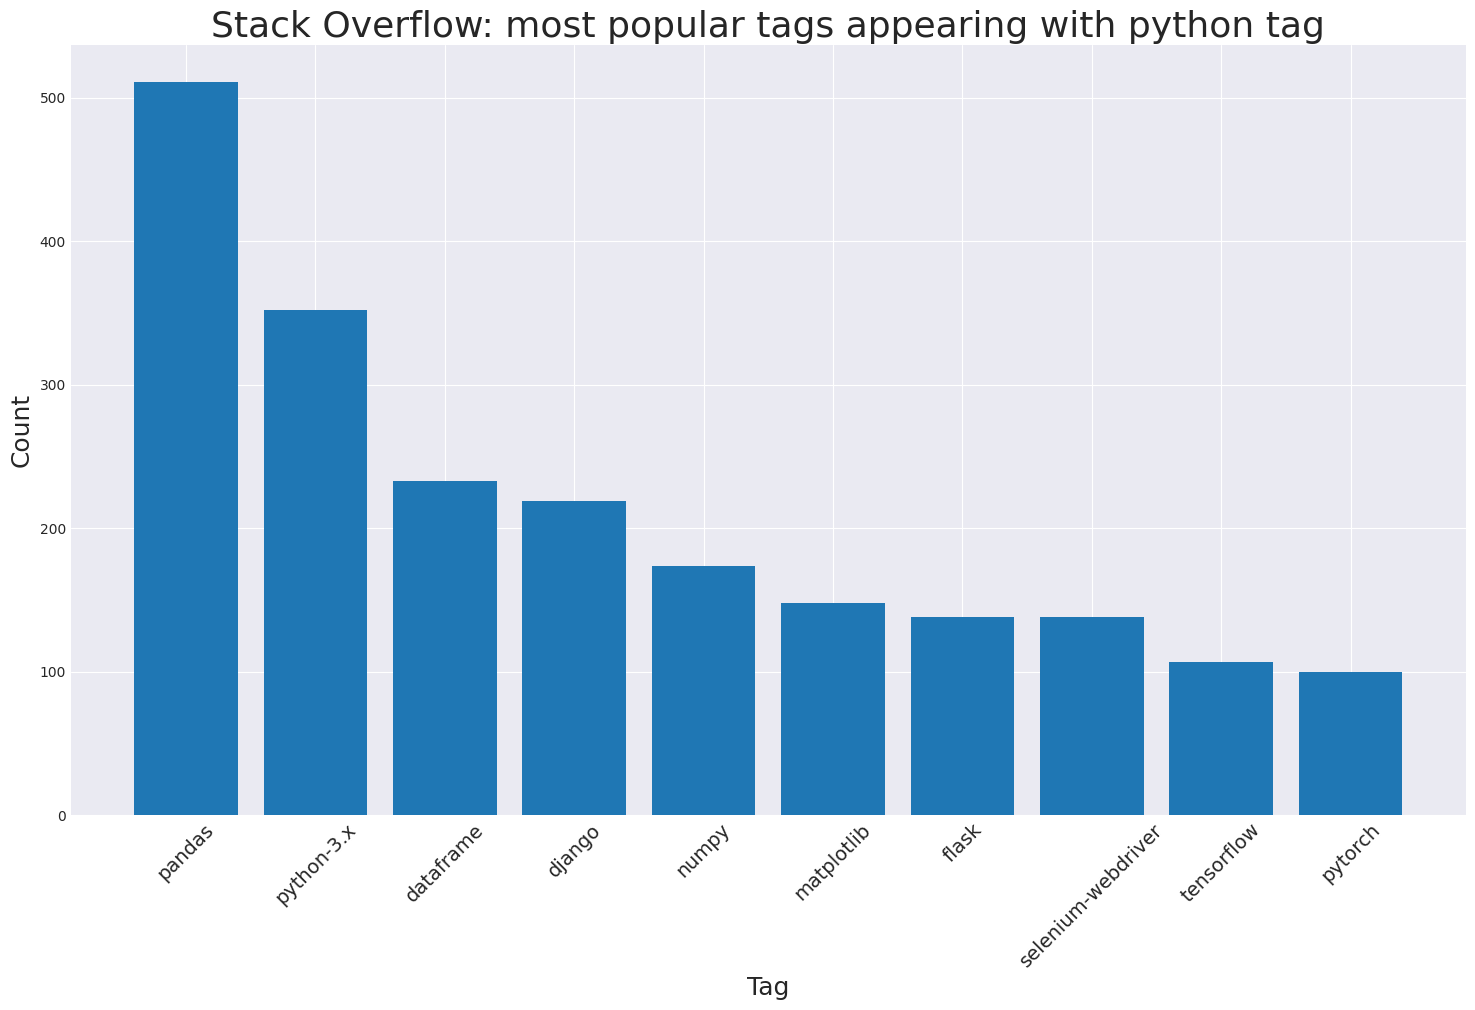

In [149]:
plt.figure(figsize=(18, 10))
plt.bar(df2_3['tag'], df2_3['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags appearing with python tag', fontsize=26)
plt.show()

## Tags appearing with `R` tag

In [150]:
posts_with_r = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .filter(f.col('tag') == 'r')\
    .withColumnRenamed('tag', 'r_tag')\
    .select('question_id', 'r_tag')
    

In [152]:
df2_4 = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .join(posts_with_r, on='question_id', how='left')\
    .filter((f.col('r_tag') == 'r') & (f.col('tag') != 'r'))\
    .groupBy('tag')\
    .count()\
    .orderBy('count', ascending=False)\
    .limit(10)\
    .toPandas()

23/12/16 14:36:44 WARN scheduler.TaskSetManager: Stage 150 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:36:44 WARN scheduler.TaskSetManager: Stage 151 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:36:44 WARN scheduler.TaskSetManager: Stage 152 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.


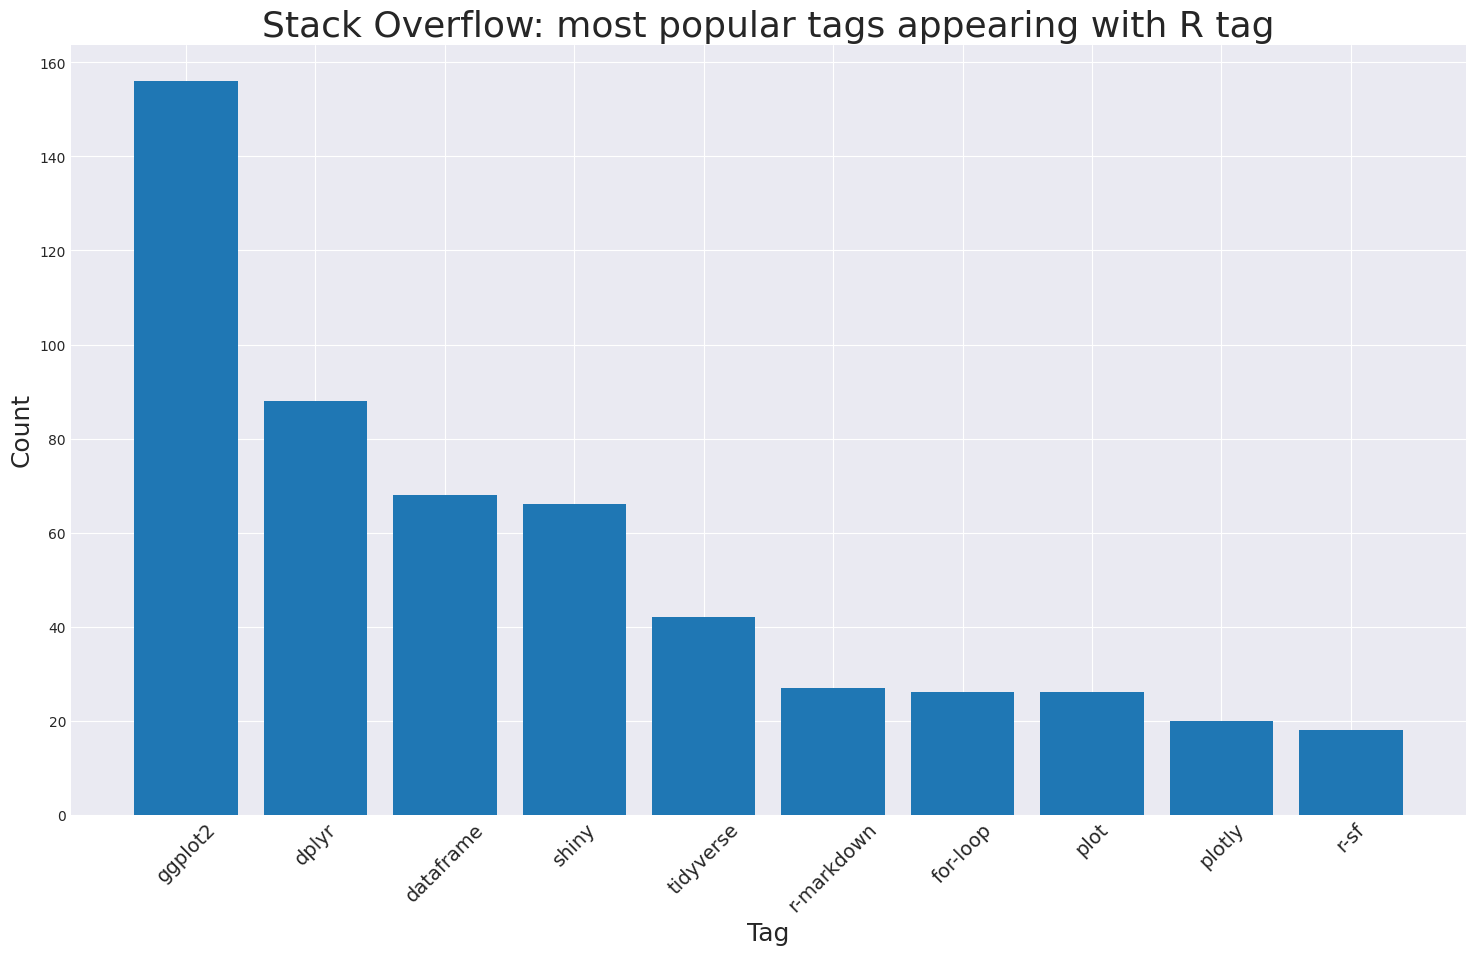

In [155]:
plt.figure(figsize=(18, 10))
plt.bar(df2_4['tag'], df2_4['count'])
plt.xlabel('Tag', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.title('Stack Overflow: most popular tags appearing with R tag', fontsize=26)
plt.show()

## Python vs R comparison in 2023 across Data Science Stack Exchange and Stack Overflow

In [168]:
df2_5_ds = df_datascience_posts\
    .join(df_datascience_tags, on='question_id')\
    .withColumn('year', f.year('creation_date'))\
    .withColumn('month', f.month('creation_date'))\
    .filter(f.col('year') == 2023)\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('month', 'tag')\
    .count()\
    .groupBy('month')\
    .pivot('tag')\
    .sum('count')\
    .filter((f.col('month') > 2) & (f.col('month') < 9))\
    .orderBy('month')\
    .withColumn('ratio', f.col('python')/f.col('r'))\
    .toPandas()

23/12/16 14:51:20 WARN scheduler.TaskSetManager: Stage 228 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:51:20 WARN scheduler.TaskSetManager: Stage 229 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:51:25 WARN scheduler.TaskSetManager: Stage 234 contains a task of very large size (1248 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:51:25 WARN scheduler.TaskSetManager: Stage 235 contains a task of very large size (1720 KiB). The maximum recommended task size is 1000 KiB.


In [169]:
df2_5_ds

,month,python,r,ratio
0,3,49,5,9.800000
1,4,52,4,13.000000
2,5,42,9,4.666667
3,6,38,3,12.666667
4,7,31,6,5.166667
5,8,37,1,37.000000


In [170]:
df2_5_stack = df_stackoverflow\
    .join(df_stackoverflow_tags, on='question_id')\
    .withColumn('year', f.year('post_creation_date'))\
    .withColumn('month', f.month('post_creation_date'))\
    .filter(f.col('year') == 2023)\
    .filter((f.col('tag') == 'r') | (f.col('tag') == 'python'))\
    .groupBy('month', 'tag')\
    .count()\
    .groupBy('month')\
    .pivot('tag')\
    .sum('count')\
    .filter((f.col('month') > 2) & (f.col('month') < 9))\
    .orderBy('month')\
    .withColumn('ratio', f.col('python')/f.col('r'))\
    .toPandas()

23/12/16 14:51:56 WARN scheduler.TaskSetManager: Stage 245 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:51:57 WARN scheduler.TaskSetManager: Stage 246 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:52:01 WARN scheduler.TaskSetManager: Stage 251 contains a task of very large size (1012 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 14:52:02 WARN scheduler.TaskSetManager: Stage 252 contains a task of very large size (2414 KiB). The maximum recommended task size is 1000 KiB.


In [171]:
df2_5_stack

,month,python,r,ratio
0,3,535,126,4.246032
1,4,503,100,5.030000
2,5,515,126,4.087302
3,6,503,116,4.336207
4,7,505,95,5.315789
5,8,455,113,4.026549


Selecting month only between 3-8 because in this period we have full data in both sources

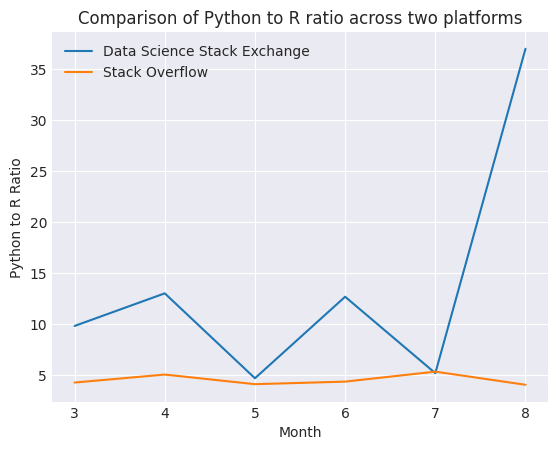

In [172]:
plt.plot(df2_5_ds['month'], df2_5_ds['ratio'], label='Data Science Stack Exchange')
plt.xlabel('Month')
plt.ylabel('Python to R Ratio')
plt.title('Comparison of Python to R ratio across two platforms')
plt.legend()
plt.show()